##### Inès Condé 2161642

# MTH8408 Projet de laboratoire 2


### Exercice 1 Méthode quasi-Newton BFGS quadratique convexe

In [1]:
using ADNLPModels, LinearAlgebra, NLPModels, Printf

In [2]:
# Solution: copier-coller votre newton_armijo ici et modifier le calcul de la direction avec la méthode de BFGS inverse skip.
function bfgs_quasi_newton_armijo(nlp, A, x0)
  T = time()
  ta=60 #temps arrêt
  N_obj_max =100 #Nombre maximum de l'évaluation de la fonction objective  
    
  #On fait la prmière boucle pour éviter les if dans la boucle du while  
  xk1=x0
  Id = Matrix(I,length(x0),length(x0))
  Hk = Id  
  fk = obj(nlp,xk1)
  gk1 = grad(nlp,xk1)
  dk= - Hk*gk1
  alpha= - (dk'*A*dk)\(gk1'*dk) #Calcul du paramètre de la recherche linéaire
  xk = xk1 + alpha * dk
  gk = grad(nlp,xk)
  sk=xk-xk1
  yk=gk-gk1
  Hk=(yk'*sk)/(yk'*yk)*Hk
  gnorm = gnorm0 = norm(gk)
  k = 1

  @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  @printf "%2d %9.2e %9.1e\n" k fk gnorm
    
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk>-1e15 && neval_obj(nlp)<N_obj_max && time()-T <ta
    sk=xk-xk1
    yk=gk-gk1
    rhok=1/(yk'*sk)
    Hk = (Id-rhok*sk*yk')*Hk*(Id-rhok*yk*sk')+rhok*sk*sk'
    dk = - Hk*gk
    alpha= - (dk'*A*dk)\(gk'*dk) #Calcul exact du paramètre de la recherche linéaire pour le cas quadratique
    xk1=xk
    xk += alpha * dk
    fk = obj(nlp,xk)
    gk1=gk
    gk = grad(nlp,xk)
    gnorm = norm(gk)
    k += 1
    @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm alpha
  end
    
  if k >= 100 
    @printf "Pas de solution car trop d'itération"
  end
  if fk<=-1e15
    @printf "Pas de solution car le problème est non-borné"
  end
  if  neval_obj(nlp)>=N_obj_max
    @printf "Pas de solution car trop d'évaluation de la fonction objectif"
  end   
  if time()-T >= ta
    @printf "Pas de solution car trop de temps"
  end  
    
  return xk
end
  

bfgs_quasi_newton_armijo (generic function with 1 method)

In [4]:
#Test
n = 10
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1))
b = A * [1:n;]

f(x) = 0.5*x'*A*x-b'*x
x0 = zeros(n)

nlp = ADNLPModel(f, x0)
bfgs_quasi_newton_armijo(nlp, A, x0)

 k        fk ||∇f(x)||
 1  0.00e+00   6.6e+00
 2 -1.10e+03   1.4e+00 1.3e+00 
 3 -1.10e+03   3.5e-01 1.5e+00 
 4 -1.10e+03   9.2e-02 1.6e+00 
 5 -1.10e+03   2.4e-02 1.6e+00 
 6 -1.10e+03   6.2e-03 1.6e+00 
 7 -1.10e+03   1.6e-03 1.6e+00 
 8 -1.10e+03   3.7e-04 1.6e+00 
 9 -1.10e+03   7.1e-05 1.7e+00 
10 -1.10e+03   3.5e-14 2.1e+00 


10-element Vector{Float64}:
  0.9999999999999997
  2.0000000000000004
  3.0000000000000004
  3.999999999999999
  5.000000000000003
  5.999999999999999
  6.999999999999995
  8.000000000000007
  8.999999999999998
 10.000000000000002

On sait que si on applique la méthode BFGS à un problème quadratique convexe, la méthode converge en au plus n étapes. De plus comme la problème est convexe, on sait que le minimum trouvé est un minimum global.  

Ici on observe que la méthode a convergé en 10 éptapes, ce qui corespond au nombre maximum. En effet, on remarque que pour l'itération 10, la valeur du gradient correspond au zéro machine. De plus, on sait que (1,2,3,4,5,6,7,8,9,10) donne le minimum global de la fonction objective qui est -1 100.  

In [5]:
x02 = Vector{Float64}([1,1,1,1,1,1,1,1,1,1])
nlp2 = ADNLPModel(f, x02)
bfgs_quasi_newton_armijo(nlp2, A, x02)

 k        fk ||∇f(x)||
 1 -2.90e+02   6.0e+00
 2 -1.10e+03   1.3e+00 1.3e+00 
 3 -1.10e+03   3.2e-01 1.5e+00 
 4 -1.10e+03   8.6e-02 1.5e+00 
 5 -1.10e+03   2.1e-02 1.6e+00 
 6 -1.10e+03   5.9e-03 1.7e+00 
 7 -1.10e+03   1.4e-03 1.6e+00 
 8 -1.10e+03   3.3e-04 1.6e+00 
 9 -1.10e+03   6.4e-05 1.7e+00 
10 -1.10e+03   1.7e-14 2.1e+00 


10-element Vector{Float64}:
  0.9999999999999999
  1.9999999999999991
  2.9999999999999996
  4.0
  4.999999999999999
  6.0
  7.0000000000000036
  7.999999999999997
  9.0
 10.0

On observe que même avec un autre point de départ, la méthode converge toujours en 10 itirations au plus et trouve bien comme solution le même minimum global.

### Exercice 2 : Etude de convergence

In [6]:
fH(x) = (x[2]+x[1]^2-11)^2+(x[1]+x[2]^2-7)^2 #fonction de Himmelblau
x0H = zeros(2)
nlpH = ADNLPModel(fH,x0H)

ADNLPModel - Model with automatic differentiation backend ADNLPModels.ForwardDiffAD{ForwardDiff.GradientConfig{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2}}}}(3, 0, ForwardDiff.GradientConfig{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2}}}((Partials(1.0, 0.0), Partials(0.0, 1.0)), ForwardDiff.Dual{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2}[Dual{ForwardDiff.Tag{typeof(fH), Float64}}(0.0,1.399521494e-315,1.39897652e-315), Dual{ForwardDiff.Tag{typeof(fH), Float64}}(0.0,1.399521494e-315,1.3988781e-315)]))
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅

In [7]:
#fonction Armijo pour résoudre la recherche linéaire
function armijo(xk, dk, fk, gk, nlp)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while obj(nlp,(xk + t * dk)) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

armijo (generic function with 1 method)

In [8]:
function newton_armijo(nlp, x0)
  T = time()
  ta=60 #temps arrêt
  N_obj_max =1000 #Nombre maximum de l'évaluation de la fonction objective
  xk  = x0
  fk = obj(nlp,xk)
  gk = grad(nlp,xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  K= [k]
  X= [xk]
  @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk>-1e15 && neval_obj(nlp)<N_obj_max && time()-T <ta
    Hk = hess(nlp,xk)
    dk = - Hk \ gk
    slope = dot(dk, gk)
    λ = 0.0
    c = 0.0 #compteur
    while slope ≥ -1.0e-4 * norm(dk) * gnorm && c<5
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
      c +=1
    end
    if slope ≥ -1.0e-4 * norm(dk) * gnorm
      dk = - gk
    end
    t = armijo(xk, dk, fk, gk, nlp)
    xk += t * dk
    X=vcat(X,[xk])  
    fk = obj(nlp,xk)
    gk = grad(nlp,xk)
    gnorm = norm(gk)
    k += 1
    K=vcat(K,[k])
    @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  if k >= 100 
    @printf "Pas de solution car trop d'itération"
  end
  if fk<=-1e15
    @printf "Pas de solution car le problème est non-borné"
  end
  if  neval_obj(nlp)>=N_obj_max
    @printf "Pas de solution car trop d'évaluation de la fonction objectif"
  end   
  if time()-T >= ta
    @printf "Pas de solution car trop de temps"
  end  
  return (xk,X,K)
end

newton_armijo (generic function with 1 method)

In [9]:
using LDLFactorizations, LinearAlgebra
function newton_ldlt_armijo(nlp, x0)
  T=time()
  ta=60 #temps arrêt
  N_obj_max =1000 #Nombre maximum de l'évaluation de la fonction objective
  xk  = x0
  fk = obj(nlp,xk)
  gk = grad(nlp,xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  K= [k]
  X= [xk]
  @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk>-1e15 && neval_obj(nlp)<N_obj_max && time()-T <ta
    Hk = hess(nlp,xk)
    # LDLFactorizations va en réalité demander la matrice triangulaire supérieure
    Hk = Symmetric(triu(Hk), :U)
    Hmk = ldl_analyze(Hk) # symbolic analysis
    if minimum(Hmk.d) <= 0
      Hmk.tol = 1e-8 #régularise les valeurs plus petites que cette tolérance
      Hmk.n_d = 0 #taille de la régularisation
      Hmk.r1 = -eps()^(1/4) # if any of the n_d first pivots D[i] < ϵ, then D[i] += S.r1 
      Hmk.r2 = eps()^(1/2) # if any of the n - n_d last pivots D[i] < ϵ, then D[i] += LDL.r2 
    end
    ldl_factorize!(Hk, Hmk)
    λmin = minimum(Hmk.d)
    if λmin ≤ 0.0
       Hmk.d = Hmk.d .+ (abs(λmin)+ 1.0e-6) # or do abs.(Hmk.d)
    end
    dk = - (Hmk \ gk)
    t = armijo(xk, dk, fk, gk, nlp)
    xk += t * dk
    X=vcat(X,[xk]) 
    fk = obj(nlp,xk)
    gk = grad(nlp,xk)
    gnorm = norm(gk)
    k += 1
    K=vcat(K,[k])
    @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  if k >= 100 
    return "Pas de solution car trop d'itération"
  end
  if fk<=-1e15
    return "Pas de solution car le problème est non-borné"
  end
  if  neval_obj(nlp)>=N_obj_max
    return "Pas de solution car trop d'évaluation de la fonction objectif"
  end   
  if time()-T >= ta
    return "Pas de solution car trop de temps"
  end  
  return (xk,X,K)
end

newton_ldlt_armijo (generic function with 1 method)

In [10]:
function bfgs_quasi_newton_armijo(nlp, x0)
  T = time()
  ta=60 #temps arrêt
  N_obj_max =1000 #Nombre maximum de l'évaluation de la fonction objective  
  xk1=x0
  Id = Matrix(I,length(x0),length(x0))
  Hk = Id
  fk = obj(nlp,xk1)
  gk1 = grad(nlp,xk1)
  dk= - Hk*gk1
  t = armijo(xk1, dk, fk, gk1, nlp)
  xk = xk1 + t * dk
  gk = grad(nlp,xk)
  sk=xk-xk1
  yk=gk-gk1
  Hk=(yk'*sk)/(yk'*yk)*Hk
  gnorm = gnorm0 = norm(gk)
  k = 1
  K= [0,1]
  X= [xk1,xk]
  @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk>-1e15 && neval_obj(nlp)<N_obj_max && time()-T <ta
    sk=xk-xk1
    yk=gk-gk1
    rhok=1/(yk'*sk)
    Hk = (Id-rhok*sk*yk')*Hk*(Id-rhok*yk*sk')+rhok*sk*sk'
    dk = - Hk*gk
    t = armijo(xk, dk, fk, gk, nlp)
    xk1=xk
    xk += t * dk
    X=vcat(X,[xk]) 
    fk = obj(nlp,xk)
    gk1=gk
    gk = grad(nlp,xk)
    gnorm = norm(gk)
    k += 1
    K=vcat(K,[k])
    @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  if k >= 100 
    @printf "Pas de solution car trop d'itération"
  end
  if fk<=-1e15
    @printf "Pas de solution car le problème est non-borné"
  end
  if  neval_obj(nlp)>=N_obj_max
    @printf "Pas de solution car trop d'évaluation de la fonction objectif"
  end   
  if time()-T >= ta
    @printf "Pas de solution car trop de temps"
  end  
  return (xk,X,K)
end
  

bfgs_quasi_newton_armijo (generic function with 2 methods)

In [11]:
(x_final,Xk,K)= newton_armijo(nlpH, x0H)
(x_final_ldlt,Xk_ldlt,K_ldlt)=newton_ldlt_armijo(nlpH, x0H)
(x_final_quasi,Xk_quasi,K_quasi)=bfgs_quasi_newton_armijo(nlpH, x0H)

 k        fk ||∇f(x)||
 0  1.70e+02   2.6e+01
 1  3.26e+01   4.0e+01 1.3e-01 
 2  2.19e+01   6.9e+01 3.0e-01 
 3  6.00e-01   1.0e+01 1.0e+00 
 4  1.04e-03   4.1e-01 1.0e+00 
 5  6.53e-09   9.4e-04 1.0e+00 
 6  3.64e-19   7.2e-09 1.0e+00 
 k        fk ||∇f(x)||
 0  1.70e+02   2.6e+01
 1  6.01e+01   1.2e+02 3.1e-07 
 2  5.18e+01   1.3e+02 6.9e-07 
 3  2.39e+00   2.3e+01 1.0e+00 
 4  1.31e-02   1.6e+00 1.0e+00 
 5  5.44e-07   1.0e-02 1.0e+00 
 6  9.79e-16   4.4e-07 1.0e+00 
 k        fk ||∇f(x)||
 1  1.70e+02   4.0e+01
 2  1.78e+01   5.6e+01 1.0e+00 
 3  7.88e+00   1.2e+01 1.0e+00 
 4  5.06e+00   3.1e+01 6.7e-01 
 5  1.36e+00   8.1e+00 1.0e+00 
 6  8.95e-02   4.2e+00 1.0e+00 
 7  1.01e-02   1.4e+00 1.0e+00 
 8  3.28e-06   2.4e-02 1.0e+00 
 9  2.37e-08   1.3e-03 1.0e+00 
10  1.98e-09   4.6e-04 1.0e+00 
11  1.52e-14   1.7e-06 1.0e+00 


([3.5844283235545373, -1.8481265160977942], [[0.0, 0.0], [1.8436213991769546, 2.8971193415637857], [3.2451847119648543, 2.707987332943441], [3.426447443370212, -0.8775871471799959], [3.856072292581549, -2.1412629802120016], [3.5164805197069855, -1.526347967509817], [3.5426064830504793, -1.833482967958998], [3.5983734313625826, -1.853425193559019], [3.5841901939524137, -1.8479141877485865], [3.5844251998466232, -1.8481655707359217], [3.5844308566290697, -1.8481164880254781], [3.5844283235545373, -1.8481265160977942]], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [12]:
#Traitement des données
using Plots

#Algo newton_armijo
d_plus1=sqrt((abs(x_final[1]-Xk[1][1]))^2+(abs(x_final[2]-Xk[1][2]))^2)
Distance=[d_plus1]
CV_linear=[1]
CV_quadratic=[1]

for i in 2:length(K)
    d = d_plus1
    d_plus1=sqrt((abs(x_final[1]-Xk[i][1]))^2+(abs(x_final[2]-Xk[i][2]))^2)
    Distance=vcat(Distance,[d])
    CV_linear=vcat(CV_linear,[d_plus1/d])
    CV_quadratic=vcat(CV_quadratic,[d_plus1/d^2])
end

#Algo newton_ldlt_armijo
d_plus1=sqrt((abs(x_final_ldlt[1]-Xk_ldlt[1][1]))^2+(abs(x_final_ldlt[2]-Xk_ldlt[1][2]))^2)
Distance_ldlt=[d_plus1]
CV_linear_ldlt=[1]
CV_quadratic_ldlt=[1]

for i in 2:length(K_ldlt)
    d = d_plus1
    d_plus1=sqrt((abs(x_final_ldlt[1]-Xk_ldlt[i][1]))^2+(abs(x_final_ldlt[2]-Xk_ldlt[i][2]))^2)
    Distance_ldlt=vcat(Distance_ldlt,[d])
    CV_linear_ldlt=vcat(CV_linear_ldlt,[d_plus1/d])
    CV_quadratic_ldlt=vcat(CV_quadratic_ldlt,[d_plus1/d^2])
end

#Algo bfgs_quasi_newton_armijo
d_plus1=sqrt((abs(x_final_quasi[1]-Xk_quasi[1][1]))^2+(abs(x_final_quasi[2]-Xk_quasi[1][2]))^2)
Distance_quasi=[d_plus1]
CV_linear_quasi=[1]
CV_quadratic_quasi=[1]

for i in 2:length(K_quasi)
    d = d_plus1
    d_plus1=sqrt((abs(x_final_quasi[1]-Xk_quasi[i][1]))^2+(abs(x_final_quasi[2]-Xk_quasi[i][2]))^2)
    Distance_quasi=vcat(Distance_quasi,[d])
    CV_linear_quasi=vcat(CV_linear_quasi,[d_plus1/d])
    CV_quadratic_quasi=vcat(CV_quadratic_quasi,[d_plus1/d^2])
end

**Etude de la Distance à la solution**

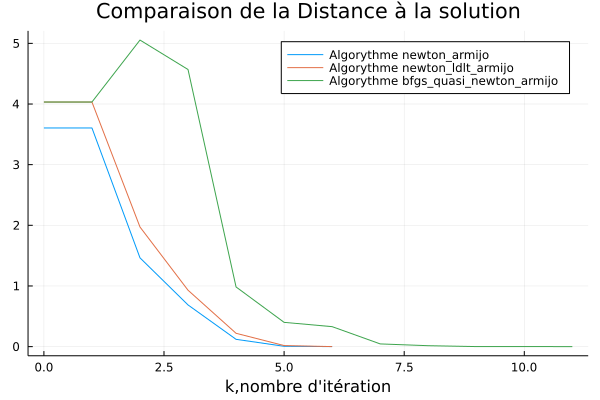

In [13]:
plot(K,Distance,label="Algorithme newton_armijo",title="Comparaison de la Distance à la solution")
xlabel!("k,nombre d'itération")
plot!(K_ldlt,Distance_ldlt,label="Algorithme newton_ldlt_armijo",)
plot!(K_quasi,Distance_quasi,label="Algorithme bfgs_quasi_newton_armijo",)


On observe que les trois distances finissent par atteindre 0 au bout d'un certain nombre d'itération. Ainsi tous les algorithmes convergent et trouvent une solution au problème. En effet, d'après les propriétées du cours, chacune de ses méthodes doivent converger de façon plus ou moins rapide. Etudions davantage cette convergence dans les prochains graphiques. 

**Etude de la convergence linéaire**

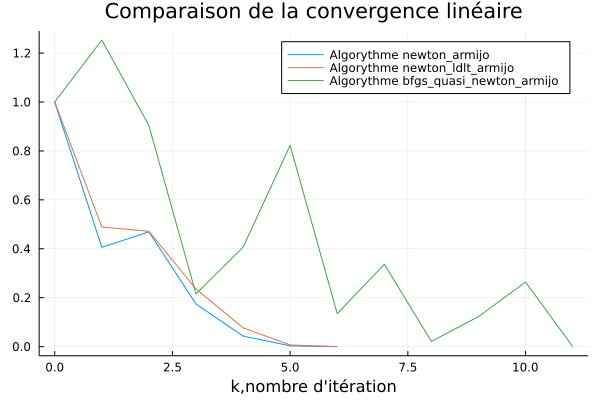

In [14]:
plot(K,CV_linear,label="Algorithme newton_armijo",title="Comparaison de la convergence linéaire")
xlabel!("k,nombre d'itération")
plot!(K_ldlt,CV_linear_ldlt,label="Algorithme newton_ldlt_armijo",)
plot!(K_quasi,CV_linear_quasi,label="Algorithme bfgs_quasi_newton_armijo",)

Pour k=0, j'ai choisit de prendre une valeur arbitraire à 0. 

On observe qu'à partir de l'itération 2, le rapport des distances (k sur k-1) est inférieur à 1. Autrement dit les algoritme se rapprochent de plus en plus rapidement de la solution. Ceci traduit une convergence linéaire. De plus, on observe que ces rapports de distance tendent vers 0 quand le nombre d'itération tend vers l'infini. Ainsi la distance entre x* et xk+1 est un petit o de la distance avec xk. La convergence de ces algoritmes est donc super linéaire. Cela rejoins les résultats du cours. 
 

**Etude de la convergence quadratique**

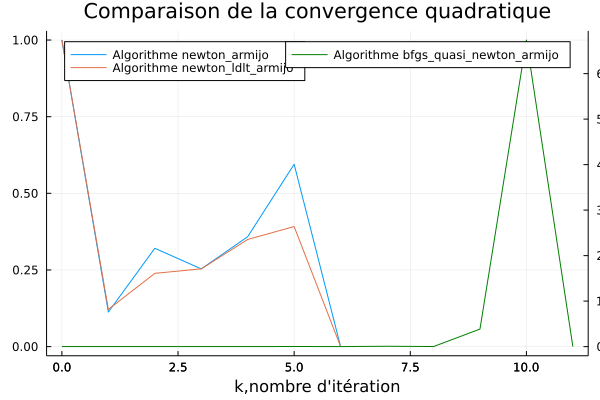

In [17]:
plot(K,CV_quadratic,label="Algorithme newton_armijo",title="Comparaison de la convergence quadratique",legend=:topleft)
xlabel!("k,nombre d'itération")
plot!(K_ldlt,CV_quadratic_ldlt,label="Algorithme newton_ldlt_armijo")
plot!(twinx(),K_quasi,CV_quadratic_quasi,label="Algorithme bfgs_quasi_newton_armijo",color=:green) #Pas même axe 


Pour k=0, j'ai choisit de prendre une valeur arbitraire à 0. De plus, pour plus de lisibilité, j'ai représenté l'algorithme bfgs_quasi_newton_armijo sur l'axe de droite car ces valeurs sont beaucoup plus grande (jusqu'à 6000) : 1000 par carreau. 

Pour les algorithmes newton_armijo et newton_ldlt_armijo, on observe que le rapport de la distance entre x* et xk sur la distance au carrée avec xk-1 est inféreieur à 1. Ainsi on peut dire que ces deux algorithme convergent quadratiquement. Cela est cependant pas le cas pour l'algorihtme bfgs_quasi_newton_armijo dont les valuers des rapports dépassent les 1000. Cela est cohérent avec les résultats vu en cours. En effet, newton_armijo et newton_ldlt_armijo utilisent la méthode de Newton classique qui offre une convergence quadratique. Or bfgs_quasi_newton_armijo utilise une méthode de Quasi-Newton qui offre une convergence super linéaire. 

### Exercice 3 : 

J'ai choisi le problème helical. 

In [18]:
using JuMP, Ipopt, MathOptInterface, NLPModels, NLPModelsJuMP, ADNLPModels, NLPModelsIpopt

**Fonction qui crée un modèle JuMP**

In [23]:
function helical_JuMP()
  J = Model(with_optimizer(Ipopt.Optimizer)) 
  x0 = [-1.0; 0.0;0.0]
  @variable(J,x[i=1:3], start=x0[i])  
  @NLobjective(J,Min,(10*(x[3]-10*(atan(x[2]/x[1])-0.25*(x[1]-abs(x[1])/x[1]))/(2*pi)))^2+(10*(sqrt(x[1]^2+x[2]^2)-1))^2+x[3]^2)
  return J
end

helical_JuMP (generic function with 1 method)

**Fonction qui crée un modèle ADNPLModel**

In [23]:
function helical()
    jump=helical_JuMP()
    nlp=MathOptNLPModel(jump)
    return nlp
end    

helical (generic function with 1 method)

In [24]:
#Vérification
nlp=helical()
NLP=ipopt(nlp)
print(NLP)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

On obtient bien la solution optimal f(-1,0,0)=0.